# Generation of λ-Nets for I-Net training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 120 #minutes



config = {
    'function_family': {
        'maximum_depth': 4,
        'beta': 1,
        'decision_sparsity': 1,
        'fully_grown': True,                      
    },
    'data': {
        'number_of_variables': 5, 
        'num_classes': 2,
        
        'function_generation_type': 'random_vanilla_decision_tree_trained', # 'make_classification' 'random_decision_tree'
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 1000, #number of samples per function
        'number_of_generated_datasets': 10000,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-2,
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [256],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', #categorical_crossentropy
        
        'number_of_lambda_weights': None,
        
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 10000,
    },     
    'evaluation': {   
        #'inet_holdout_seed_evaluation': False,
            
        'random_evaluation_dataset_size': 500,
    },    
    
    'computation':{
        'n_jobs': -5,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}




In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
from itertools import product       # forms cartesian products
from tqdm import tqdm_notebook as tqdm
from more_itertools import random_product 
import pickle
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt 
import time
import math
import operator
from functools import reduce

from scipy.signal import argrelextrema

import sys
import os

import shutil

import logging
logging.getLogger('tensorflow').disabled = True

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

from joblib import Parallel, delayed


from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
from similaritymeasures import frechet_dist, area_between_two_curves, dtw
from IPython.display import Image

from livelossplot import PlotLossesKerasTF

import seaborn as sns

import tensorflow as tf
#import tensorflow_addons as tfa
import random 


import keras
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



2021-09-06 21:45:40.769001: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64:
2021-09-06 21:45:40.769038: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################
    
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)

warnings.filterwarnings('ignore')
np.seterr(all="ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

In [5]:
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(lambda_network_layers, number_of_variables, num_classes)
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)

#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='lambda_net'))
generate_directory_structure()
generate_lambda_net_directory(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [6]:
print(path_identifier_lambda_net_data)

print(path_identifier_function_data)


lNetSize1000_numLNets10000_var5_class2_random_vanilla_decision_tree_trained_xMax1_xMin0_xDistuniform_depth4_beta1_decisionSpars1_fullyGrown/256_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42
lNetSize1000_numDatasets10000_var5_class2_random_vanilla_decision_tree_trained_xMax1_xMin0_xDistuniform_depth4_beta1_decisionSpars1_fullyGrown


In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


2021-09-06 23:45:46.425565: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64:
2021-09-06 23:45:46.425610: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
lambda_network_layers

[256]

In [9]:
path_functions = './data/saved_function_lists/functions_' + path_identifier_function_data + '.csv'
function_df = pd.read_csv(path_functions)

path_X_data = './data/saved_function_lists/X_data_' + path_identifier_function_data + '.pkl'
with open(path_X_data, 'rb') as f:
    X_data_list = pickle.load(f)
    
path_y_data = './data/saved_function_lists/y_data_' + path_identifier_function_data + '.pkl'
with open(path_y_data, 'rb') as f:
    y_data_list = pickle.load(f)
    
if number_of_trained_lambda_nets < number_of_generated_datasets:
    function_df = function_df.sample(n=number_of_trained_lambda_nets, random_state=RANDOM_SEED)
    random.seed(RANDOM_SEED)
    X_data_list = random.sample(X_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)
    y_data_list = random.sample(y_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)

2021-09-06 23:45:46.425646: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dws-05): /proc/driver/nvidia/version does not exist


## Data Inspection

In [10]:
function_df.head()

,f0v0,f0v1,f0v2,f0v3,f0v4,f1v0,f1v1,f1v2,f1v3,f1v4,f2v0,f2v1,f2v2,f2v3,f2v4,f3v0,f3v1,f3v2,f3v3,f3v4,f4v0,f4v1,f4v2,f4v3,f4v4,f5v0,f5v1,f5v2,f5v3,f5v4,f6v0,f6v1,f6v2,f6v3,f6v4,f7v0,f7v1,f7v2,f7v3,f7v4,f8v0,f8v1,f8v2,f8v3,f8v4,f9v0,f9v1,f9v2,f9v3,f9v4,f10v0,f10v1,f10v2,f10v3,f10v4,f11v0,f11v1,f11v2,f11v3,f11v4,f12v0,f12v1,f12v2,f12v3,f12v4,f13v0,f13v1,f13v2,f13v3,f13v4,f14v0,f14v1,f14v2,f14v3,f14v4,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,lp0c0,lp0c1,lp1c0,lp1c1,lp2c0,lp2c1,lp3c0,lp3c1,lp4c0,lp4c1,lp5c0,lp5c1,lp6c0,lp6c1,lp7c0,lp7c1,lp8c0,lp8c1,lp9c0,lp9c1,lp10c0,lp10c1,lp11c0,lp11c1,lp12c0,lp12c1,lp13c0,lp13c1,lp14c0,lp14c1,lp15c0,lp15c1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
X_data_list[0][0].head(10)

f0v0    0
f0v1    0
f0v2    0
f0v3    0
f0v4    0
f1v0    0
f1v1    0
f1v2    0
f1v3    0
f1v4    0
dtype: int64

In [12]:
X_data_list[0][1].head(10)

,x0,x1,x2,x3,x4
0,0.549,0.715,0.603,0.545,0.424
1,0.646,0.438,0.892,0.964,0.383
2,0.792,0.529,0.568,0.926,0.071
3,0.087,0.020,0.833,0.778,0.870
4,0.979,0.799,0.461,0.781,0.118
5,0.640,0.143,0.945,0.522,0.415
6,0.265,0.774,0.456,0.568,0.019
7,0.618,0.612,0.617,0.944,0.682
8,0.360,0.437,0.698,0.060,0.667
9,0.671,0.210,0.129,0.315,0.364


In [13]:
y_data_list[0][0].head(10)

f0v0    0
f0v1    0
f0v2    0
f0v3    0
f0v4    0
f1v0    0
f1v1    0
f1v2    0
f1v3    0
f1v4    0
dtype: int64

In [14]:
y_data_list[0][1].head(10)

,result
0,1
1,0
2,1
3,0
4,1
5,0
6,1
7,1
8,1
9,1


In [15]:
def inject_noise(y_data, noise=0.0, noise_dist='normal', seed=42):
    """
    Returns a polynomial injected with specified noise type and amount. 
    Inputs a clean polynomial array with x-data and y-data and modifies the y-data according to the noise settings.
    """
    np.random.seed(seed)
    
    #Calculate range of function values of input polynomial
    range_values_fv = np.ptp(y_data[1].values)
    
    #Selection of noise type
    #Available types: normal, uniform, A, B, C
    if noise_dist=='normal':
        noise_sample=noise*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform':
        noise_sample=noise*np.random.uniform(low=0, high=1.0,size=y_data[1].shape[0])
    elif noise_dist=='normal_range':
        #Normal distribution adjusted to function value range
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform_range':
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='flip_percentage':
        idx = np.random.choice(y_data[1].shape[0], int(y_data[1].shape[0]*noise), replace=False)
        y_data[1].iloc[idx] = (y_data[1].iloc[idx] + 1) % 2 
        #y_data[1].reshape(-1, 1)
        return y_data
    else:
        #no noise
        noise_sample = np.zeros(y_data[1].shape[0])
                               
    noise_sample=noise_sample.reshape(-1,1)
    
    y_data[1]=y_data[1]+noise_sample
    
    return np.clip(y_data, 0, 1)

In [16]:
if noise_injected_level > 0:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    y_data_list = parallel(delayed(inject_noise)(y_data=y_data_list[i],
                                                 noise=noise_injected_level,
                                                 noise_dist=noise_injected_type, 
                                                 seed=RANDOM_SEED+i) for i in range(len(y_data_list)))


In [17]:
y_data_list[0][0].head(10)

f0v0    0
f0v1    0
f0v2    0
f0v3    0
f0v4    0
f1v0    0
f1v1    0
f1v2    0
f1v3    0
f1v4    0
dtype: int64

In [18]:
y_data_list[0][0]

f0v0      0
f0v1      0
f0v2      0
f0v3      0
f0v4      0
         ..
lp13c1    0
lp14c0    0
lp14c1    0
lp15c0    0
lp15c1    0
Length: 122, dtype: int64

In [19]:
y_data_list[0][1].head(10)

,result
0,1
1,0
2,1
3,0
4,1
5,0
6,1
7,1
8,1
9,1


## Lambda Network Training + Weigh/Bias saving

In [20]:
#%load_ext autoreload

In [21]:
rand_index = np.random.randint(number_of_trained_lambda_nets)

#rand_tree = generate_decision_tree_from_array(y_data_list[rand_index][0].values, config)
#rand_tree.plot_tree()

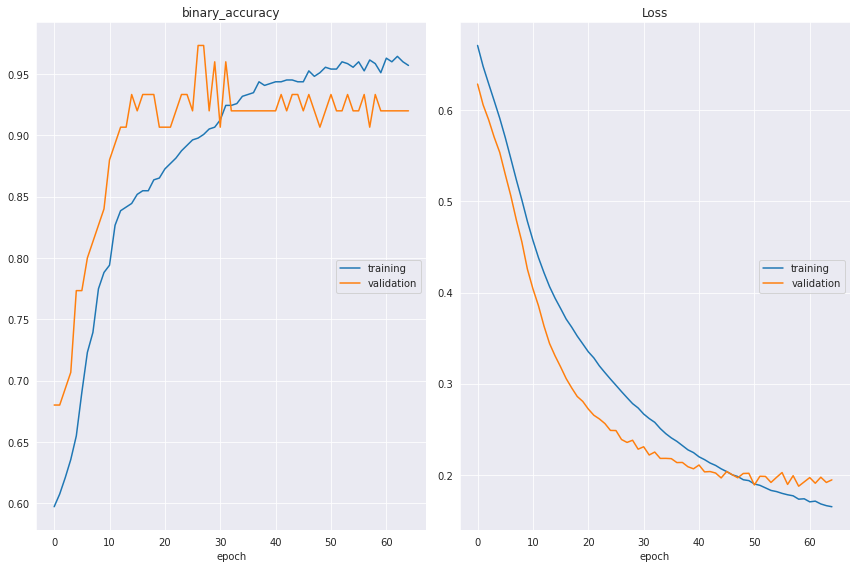

binary_accuracy
	training         	 (min:    0.597, max:    0.964, cur:    0.957)
	validation       	 (min:    0.680, max:    0.973, cur:    0.920)
Loss
	training         	 (min:    0.165, max:    0.671, cur:    0.165)
	validation       	 (min:    0.188, max:    0.629, cur:    0.194)


In [25]:
#%autoreload 2
random_network = train_lambda_net(config=config,
                                  lambda_index=rand_index, 
                                  X_data_with_function=X_data_list[rand_index], 
                                  y_data_with_function=y_data_list[rand_index], 
                                  callbacks=[PlotLossesKerasTF()], 
                                  return_model=True,
                                  printing=False)

In [23]:
#%autoreload 2
parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky
clf_list = parallel(delayed(train_lambda_net)(config=config,
                                              lambda_index=index, 
                                              X_data_with_function=X_data, 
                                              y_data_with_function=y_data,
                                              return_history=True, 
                                              printing=True) for index, (X_data, y_data) in enumerate(zip(X_data_list, y_data_list)))  
del parallel

[Parallel(n_jobs=-5)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-5)]: Done   8 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-5)]: Done 104 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-5)]: Done 264 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-5)]: Done 488 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-5)]: Done 776 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-5)]: Done 1128 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-5)]: Done 1544 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-5)]: Done 2024 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-5)]: Done 2568 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-5)]: Done 3176 tasks      | elapsed: 29.7min
[Parallel(n_jobs=-5)]: Done 3848 tasks      | elapsed: 35.8min
[Parallel(n_jobs=-5)]: Done 4584 tasks      | elapsed: 42.7min
[Parallel(n_jobs=-5)]: Done 5384 tasks      | elapsed: 50.0min
[Parallel(n_jobs=-5)]: Done 6248 tasks      | elapsed: 58.0min
[Parallel(n_jobs=-5)]: Done 7176 tasks      | 

In [26]:
random_network['model'].get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 5),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dense_input'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'batch_input_shape': (None, 5),
    'dtype': 'float32',
    'units': 256,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': 42}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'dtype': 'float32',
    'units': 1,
    'activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': 42}},
    'bias_initializ

In [27]:
random_network['model'].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               1536      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 1,793
Trainable params: 1,793
Non-trainable params: 0
_________________________________________________________________


## Save and Plot Lambda-Model History

In [28]:
loss_list_total = []
metric_list_total = []

val_loss_list_total = []
val_metric_list_total = []

index_list = []


max_training_epochs = 0
for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    max_training_epochs = max(max_training_epochs, current_training_epochs)


for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    index = entry['index']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    
    loss_list = np.full(max_training_epochs, np.nan)
    metric_list = np.full(max_training_epochs, np.nan)
    val_loss_list = np.full(max_training_epochs, np.nan)
    val_metric_list = np.full(max_training_epochs, np.nan) 

    for i in range(current_training_epochs):  
        loss_list[i] = history[list(history.keys())[0]][i]
        metric_list[i] = history[list(history.keys())[1]][i]
        val_loss_list[i] = history[list(history.keys())[len(history.keys())//2]][i]
        val_metric_list[i] = history[list(history.keys())[len(history.keys())//2+1]][i]
    
    index_list.append([index])
    loss_list_total.append(loss_list)
    metric_list_total.append(metric_list)
    val_loss_list_total.append(val_loss_list)
    val_metric_list_total.append(val_metric_list)

loss_df = pd.DataFrame(data=np.hstack([index_list, loss_list_total]), columns=flatten_list(['index', [list(history.keys())[0] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#loss_df['index'] = loss_df['index'].astype(int)
metric_df = pd.DataFrame(data=np.hstack([index_list, metric_list_total]), columns=flatten_list(['index', [list(history.keys())[1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#metric_df['index'] = metric_df['index'].astype(int)
val_loss_df = pd.DataFrame(data=np.hstack([index_list, val_loss_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#val_loss_df['index'] = val_loss_df['index'].astype(int)
val_metric_df = pd.DataFrame(data=np.hstack([index_list, val_metric_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2+1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]])) 
#val_metric_df['index'] = val_metric_df['index'].astype(int)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [29]:
path_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[0] + '.txt'
path_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[1] + '.txt'
path_val_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2] + '.txt'
path_val_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2+1] + '.txt'

loss_df.to_csv(path_loss, index=None, sep=',')
metric_df.to_csv(path_metric, index=None, sep=',')
val_loss_df.to_csv(path_val_loss, index=None, sep=',')
val_metric_df.to_csv(path_val_metric, index=None, sep=',')


In [30]:
loss_df.describe()

,index,loss_epoch_1,loss_epoch_2,loss_epoch_3,loss_epoch_4,loss_epoch_5,loss_epoch_6,loss_epoch_7,loss_epoch_8,loss_epoch_9,loss_epoch_10,loss_epoch_11,loss_epoch_12,loss_epoch_13,loss_epoch_14,loss_epoch_15,loss_epoch_16,loss_epoch_17,loss_epoch_18,loss_epoch_19,loss_epoch_20,loss_epoch_21,loss_epoch_22,loss_epoch_23,loss_epoch_24,loss_epoch_25,loss_epoch_26,loss_epoch_27,loss_epoch_28,loss_epoch_29,loss_epoch_30,loss_epoch_31,loss_epoch_32,loss_epoch_33,loss_epoch_34,loss_epoch_35,loss_epoch_36,loss_epoch_37,loss_epoch_38,loss_epoch_39,loss_epoch_40,loss_epoch_41,loss_epoch_42,loss_epoch_43,loss_epoch_44,loss_epoch_45,loss_epoch_46,loss_epoch_47,loss_epoch_48,loss_epoch_49,loss_epoch_50,loss_epoch_51,loss_epoch_52,loss_epoch_53,loss_epoch_54,loss_epoch_55,loss_epoch_56,loss_epoch_57,loss_epoch_58,loss_epoch_59,loss_epoch_60,loss_epoch_61,loss_epoch_62,loss_epoch_63,loss_epoch_64,loss_epoch_65,loss_epoch_66,loss_epoch_67,loss_epoch_68,loss_epoch_69,loss_epoch_70,loss_epoch_71,loss_epoch_72,loss_epoch_73,loss_epoch_74,loss_epoch_75,loss_epoch_76,loss_epoch_77,loss_epoch_78,loss_epoch_79,loss_epoch_80,loss_epoch_81,loss_epoch_82,loss_epoch_83,loss_epoch_84,loss_epoch_85,loss_epoch_86,loss_epoch_87,loss_epoch_88,loss_epoch_89,loss_epoch_90,loss_epoch_91,loss_epoch_92,loss_epoch_93,loss_epoch_94,loss_epoch_95,loss_epoch_96,loss_epoch_97,loss_epoch_98,loss_epoch_99,...,loss_epoch_380,loss_epoch_381,loss_epoch_382,loss_epoch_383,loss_epoch_384,loss_epoch_385,loss_epoch_386,loss_epoch_387,loss_epoch_388,loss_epoch_389,loss_epoch_390,loss_epoch_391,loss_epoch_392,loss_epoch_393,loss_epoch_394,loss_epoch_395,loss_epoch_396,loss_epoch_397,loss_epoch_398,loss_epoch_399,loss_epoch_400,loss_epoch_401,loss_epoch_402,loss_epoch_403,loss_epoch_404,loss_epoch_405,loss_epoch_406,loss_epoch_407,loss_epoch_408,loss_epoch_409,loss_epoch_410,loss_epoch_411,loss_epoch_412,loss_epoch_413,loss_epoch_414,loss_epoch_415,loss_epoch_416,loss_epoch_417,loss_epoch_418,loss_epoch_419,loss_epoch_420,loss_epoch_421,loss_epoch_422,loss_epoch_423,loss_epoch_424,loss_epoch_425,loss_epoch_426,loss_epoch_427,loss_epoch_428,loss_epoch_429,loss_epoch_430,loss_epoch_431,loss_epoch_432,loss_epoch_433,loss_epoch_434,loss_epoch_435,loss_epoch_436,loss_epoch_437,loss_epoch_438,loss_epoch_439,loss_epoch_440,loss_epoch_441,loss_epoch_442,loss_epoch_443,loss_epoch_444,loss_epoch_445,loss_epoch_446,loss_epoch_447,loss_epoch_448,loss_epoch_449,loss_epoch_450,loss_epoch_451,loss_epoch_452,loss_epoch_453,loss_epoch_454,loss_epoch_455,loss_epoch_456,loss_epoch_457,loss_epoch_458,loss_epoch_459,loss_epoch_460,loss_epoch_461,loss_epoch_462,loss_epoch_463,loss_epoch_464,loss_epoch_465,loss_epoch_466,loss_epoch_467,loss_epoch_468,loss_epoch_469,loss_epoch_470,loss_epoch_471,loss_epoch_472,loss_epoch_473,loss_epoch_474,loss_epoch_475,loss_epoch_476,loss_epoch_477,loss_epoch_478,loss_epoch_479
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,9988.000,9980.000,9975.000,9969.000,9966.000,9963.000,9954.000,9947.000,9939.000,9929.000,9917.000,9904.000,9894.000,9876.000,9857.000,9840.000,9823.000,9810.000,9795.000,9778.000,9761.000,9747.000,9724.000,9696.000,9678.000,9661.000,9643.000,9630.000,9609.000,9593.000,9568.000,9549.000,9524.000,9493.000,9457.000,9425.000,9398.000,9365.000,9333.000,9298.000,9270.000,9236.000,9193.000,9166.000,9135.000,9088.000,9044.000,8995.000,8947.000,8907.000,8864.000,8815.000,8768.000,8711.000,8654.000,8602.000,8537.000,8477.000,8416.000,8365.000,8303.000,8226.000,8153.000,8083.000,8009.000,7934.000,7847.000,7770.000,7673.000,7577.000,7485.000,7375.000,7264.000,7165.000,7074.000,6980.000,6893.000,6801.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,

In [31]:
val_loss_df.describe()

,index,val_loss_epoch_1,val_loss_epoch_2,val_loss_epoch_3,val_loss_epoch_4,val_loss_epoch_5,val_loss_epoch_6,val_loss_epoch_7,val_loss_epoch_8,val_loss_epoch_9,val_loss_epoch_10,val_loss_epoch_11,val_loss_epoch_12,val_loss_epoch_13,val_loss_epoch_14,val_loss_epoch_15,val_loss_epoch_16,val_loss_epoch_17,val_loss_epoch_18,val_loss_epoch_19,val_loss_epoch_20,val_loss_epoch_21,val_loss_epoch_22,val_loss_epoch_23,val_loss_epoch_24,val_loss_epoch_25,val_loss_epoch_26,val_loss_epoch_27,val_loss_epoch_28,val_loss_epoch_29,val_loss_epoch_30,val_loss_epoch_31,val_loss_epoch_32,val_loss_epoch_33,val_loss_epoch_34,val_loss_epoch_35,val_loss_epoch_36,val_loss_epoch_37,val_loss_epoch_38,val_loss_epoch_39,val_loss_epoch_40,val_loss_epoch_41,val_loss_epoch_42,val_loss_epoch_43,val_loss_epoch_44,val_loss_epoch_45,val_loss_epoch_46,val_loss_epoch_47,val_loss_epoch_48,val_loss_epoch_49,val_loss_epoch_50,val_loss_epoch_51,val_loss_epoch_52,val_loss_epoch_53,val_loss_epoch_54,val_loss_epoch_55,val_loss_epoch_56,val_loss_epoch_57,val_loss_epoch_58,val_loss_epoch_59,val_loss_epoch_60,val_loss_epoch_61,val_loss_epoch_62,val_loss_epoch_63,val_loss_epoch_64,val_loss_epoch_65,val_loss_epoch_66,val_loss_epoch_67,val_loss_epoch_68,val_loss_epoch_69,val_loss_epoch_70,val_loss_epoch_71,val_loss_epoch_72,val_loss_epoch_73,val_loss_epoch_74,val_loss_epoch_75,val_loss_epoch_76,val_loss_epoch_77,val_loss_epoch_78,val_loss_epoch_79,val_loss_epoch_80,val_loss_epoch_81,val_loss_epoch_82,val_loss_epoch_83,val_loss_epoch_84,val_loss_epoch_85,val_loss_epoch_86,val_loss_epoch_87,val_loss_epoch_88,val_loss_epoch_89,val_loss_epoch_90,val_loss_epoch_91,val_loss_epoch_92,val_loss_epoch_93,val_loss_epoch_94,val_loss_epoch_95,val_loss_epoch_96,val_loss_epoch_97,val_loss_epoch_98,val_loss_epoch_99,...,val_loss_epoch_380,val_loss_epoch_381,val_loss_epoch_382,val_loss_epoch_383,val_loss_epoch_384,val_loss_epoch_385,val_loss_epoch_386,val_loss_epoch_387,val_loss_epoch_388,val_loss_epoch_389,val_loss_epoch_390,val_loss_epoch_391,val_loss_epoch_392,val_loss_epoch_393,val_loss_epoch_394,val_loss_epoch_395,val_loss_epoch_396,val_loss_epoch_397,val_loss_epoch_398,val_loss_epoch_399,val_loss_epoch_400,val_loss_epoch_401,val_loss_epoch_402,val_loss_epoch_403,val_loss_epoch_404,val_loss_epoch_405,val_loss_epoch_406,val_loss_epoch_407,val_loss_epoch_408,val_loss_epoch_409,val_loss_epoch_410,val_loss_epoch_411,val_loss_epoch_412,val_loss_epoch_413,val_loss_epoch_414,val_loss_epoch_415,val_loss_epoch_416,val_loss_epoch_417,val_loss_epoch_418,val_loss_epoch_419,val_loss_epoch_420,val_loss_epoch_421,val_loss_epoch_422,val_loss_epoch_423,val_loss_epoch_424,val_loss_epoch_425,val_loss_epoch_426,val_loss_epoch_427,val_loss_epoch_428,val_loss_epoch_429,val_loss_epoch_430,val_loss_epoch_431,val_loss_epoch_432,val_loss_epoch_433,val_loss_epoch_434,val_loss_epoch_435,val_loss_epoch_436,val_loss_epoch_437,val_loss_epoch_438,val_loss_epoch_439,val_loss_epoch_440,val_loss_epoch_441,val_loss_epoch_442,val_loss_epoch_443,val_loss_epoch_444,val_loss_epoch_445,val_loss_epoch_446,val_loss_epoch_447,val_loss_epoch_448,val_loss_epoch_449,val_loss_epoch_450,val_loss_epoch_451,val_loss_epoch_452,val_loss_epoch_453,val_loss_epoch_454,val_loss_epoch_455,val_loss_epoch_456,val_loss_epoch_457,val_loss_epoch_458,val_loss_epoch_459,val_loss_epoch_460,val_loss_epoch_461,val_loss_epoch_462,val_loss_epoch_463,val_loss_epoch_464,val_loss_epoch_465,val_loss_epoch_466,val_loss_epoch_467,val_loss_epoch_468,val_loss_epoch_469,val_loss_epoch_470,val_loss_epoch_471,val_loss_epoch_472,val_loss_epoch_473,val_loss_epoch_474,val_loss_epoch_475,val_loss_epoch_476,val_loss_epoch_477,val_loss_epoch_478,val_loss_epoch_479
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,9988.000,9980.000,9975.000,9969.000,9966.000,9963.000,9954.000,9947.000,9939.000,9929.000,

In [32]:
metric_df.describe()

,index,binary_accuracy_epoch_1,binary_accuracy_epoch_2,binary_accuracy_epoch_3,binary_accuracy_epoch_4,binary_accuracy_epoch_5,binary_accuracy_epoch_6,binary_accuracy_epoch_7,binary_accuracy_epoch_8,binary_accuracy_epoch_9,binary_accuracy_epoch_10,binary_accuracy_epoch_11,binary_accuracy_epoch_12,binary_accuracy_epoch_13,binary_accuracy_epoch_14,binary_accuracy_epoch_15,binary_accuracy_epoch_16,binary_accuracy_epoch_17,binary_accuracy_epoch_18,binary_accuracy_epoch_19,binary_accuracy_epoch_20,binary_accuracy_epoch_21,binary_accuracy_epoch_22,binary_accuracy_epoch_23,binary_accuracy_epoch_24,binary_accuracy_epoch_25,binary_accuracy_epoch_26,binary_accuracy_epoch_27,binary_accuracy_epoch_28,binary_accuracy_epoch_29,binary_accuracy_epoch_30,binary_accuracy_epoch_31,binary_accuracy_epoch_32,binary_accuracy_epoch_33,binary_accuracy_epoch_34,binary_accuracy_epoch_35,binary_accuracy_epoch_36,binary_accuracy_epoch_37,binary_accuracy_epoch_38,binary_accuracy_epoch_39,binary_accuracy_epoch_40,binary_accuracy_epoch_41,binary_accuracy_epoch_42,binary_accuracy_epoch_43,binary_accuracy_epoch_44,binary_accuracy_epoch_45,binary_accuracy_epoch_46,binary_accuracy_epoch_47,binary_accuracy_epoch_48,binary_accuracy_epoch_49,binary_accuracy_epoch_50,binary_accuracy_epoch_51,binary_accuracy_epoch_52,binary_accuracy_epoch_53,binary_accuracy_epoch_54,binary_accuracy_epoch_55,binary_accuracy_epoch_56,binary_accuracy_epoch_57,binary_accuracy_epoch_58,binary_accuracy_epoch_59,binary_accuracy_epoch_60,binary_accuracy_epoch_61,binary_accuracy_epoch_62,binary_accuracy_epoch_63,binary_accuracy_epoch_64,binary_accuracy_epoch_65,binary_accuracy_epoch_66,binary_accuracy_epoch_67,binary_accuracy_epoch_68,binary_accuracy_epoch_69,binary_accuracy_epoch_70,binary_accuracy_epoch_71,binary_accuracy_epoch_72,binary_accuracy_epoch_73,binary_accuracy_epoch_74,binary_accuracy_epoch_75,binary_accuracy_epoch_76,binary_accuracy_epoch_77,binary_accuracy_epoch_78,binary_accuracy_epoch_79,binary_accuracy_epoch_80,binary_accuracy_epoch_81,binary_accuracy_epoch_82,binary_accuracy_epoch_83,binary_accuracy_epoch_84,binary_accuracy_epoch_85,binary_accuracy_epoch_86,binary_accuracy_epoch_87,binary_accuracy_epoch_88,binary_accuracy_epoch_89,binary_accuracy_epoch_90,binary_accuracy_epoch_91,binary_accuracy_epoch_92,binary_accuracy_epoch_93,binary_accuracy_epoch_94,binary_accuracy_epoch_95,binary_accuracy_epoch_96,binary_accuracy_epoch_97,binary_accuracy_epoch_98,binary_accuracy_epoch_99,...,binary_accuracy_epoch_380,binary_accuracy_epoch_381,binary_accuracy_epoch_382,binary_accuracy_epoch_383,binary_accuracy_epoch_384,binary_accuracy_epoch_385,binary_accuracy_epoch_386,binary_accuracy_epoch_387,binary_accuracy_epoch_388,binary_accuracy_epoch_389,binary_accuracy_epoch_390,binary_accuracy_epoch_391,binary_accuracy_epoch_392,binary_accuracy_epoch_393,binary_accuracy_epoch_394,binary_accuracy_epoch_395,binary_accuracy_epoch_396,binary_accuracy_epoch_397,binary_accuracy_epoch_398,binary_accuracy_epoch_399,binary_accuracy_epoch_400,binary_accuracy_epoch_401,binary_accuracy_epoch_402,binary_accuracy_epoch_403,binary_accuracy_epoch_404,binary_accuracy_epoch_405,binary_accuracy_epoch_406,binary_accuracy_epoch_407,binary_accuracy_epoch_408,binary_accuracy_epoch_409,binary_accuracy_epoch_410,binary_accuracy_epoch_411,binary_accuracy_epoch_412,binary_accuracy_epoch_413,binary_accuracy_epoch_414,binary_accuracy_epoch_415,binary_accuracy_epoch_416,binary_accuracy_epoch_417,binary_accuracy_epoch_418,binary_accuracy_epoch_419,binary_accuracy_epoch_420,binary_accuracy_epoch_421,binary_accuracy_epoch_422,binary_accuracy_epoch_423,binary_accuracy_epoch_424,binary_accuracy_epoch_425,binary_accuracy_epoch_426,binary_accuracy_epoch_427,binary_accuracy_epoch_428,binary_accuracy_epoch_429,binary_accuracy_epoch_430,binary_accuracy_epoch_431,binary_accuracy_epoch_432,binary_accuracy_epoch_433,binary_accuracy_epoch_434,binary_accuracy_epoch_435,binary_accuracy_epoch_436,binary_accuracy_epoch_437,binary_accuracy

In [33]:
val_metric_df.describe()

,index,val_binary_accuracy_epoch_1,val_binary_accuracy_epoch_2,val_binary_accuracy_epoch_3,val_binary_accuracy_epoch_4,val_binary_accuracy_epoch_5,val_binary_accuracy_epoch_6,val_binary_accuracy_epoch_7,val_binary_accuracy_epoch_8,val_binary_accuracy_epoch_9,val_binary_accuracy_epoch_10,val_binary_accuracy_epoch_11,val_binary_accuracy_epoch_12,val_binary_accuracy_epoch_13,val_binary_accuracy_epoch_14,val_binary_accuracy_epoch_15,val_binary_accuracy_epoch_16,val_binary_accuracy_epoch_17,val_binary_accuracy_epoch_18,val_binary_accuracy_epoch_19,val_binary_accuracy_epoch_20,val_binary_accuracy_epoch_21,val_binary_accuracy_epoch_22,val_binary_accuracy_epoch_23,val_binary_accuracy_epoch_24,val_binary_accuracy_epoch_25,val_binary_accuracy_epoch_26,val_binary_accuracy_epoch_27,val_binary_accuracy_epoch_28,val_binary_accuracy_epoch_29,val_binary_accuracy_epoch_30,val_binary_accuracy_epoch_31,val_binary_accuracy_epoch_32,val_binary_accuracy_epoch_33,val_binary_accuracy_epoch_34,val_binary_accuracy_epoch_35,val_binary_accuracy_epoch_36,val_binary_accuracy_epoch_37,val_binary_accuracy_epoch_38,val_binary_accuracy_epoch_39,val_binary_accuracy_epoch_40,val_binary_accuracy_epoch_41,val_binary_accuracy_epoch_42,val_binary_accuracy_epoch_43,val_binary_accuracy_epoch_44,val_binary_accuracy_epoch_45,val_binary_accuracy_epoch_46,val_binary_accuracy_epoch_47,val_binary_accuracy_epoch_48,val_binary_accuracy_epoch_49,val_binary_accuracy_epoch_50,val_binary_accuracy_epoch_51,val_binary_accuracy_epoch_52,val_binary_accuracy_epoch_53,val_binary_accuracy_epoch_54,val_binary_accuracy_epoch_55,val_binary_accuracy_epoch_56,val_binary_accuracy_epoch_57,val_binary_accuracy_epoch_58,val_binary_accuracy_epoch_59,val_binary_accuracy_epoch_60,val_binary_accuracy_epoch_61,val_binary_accuracy_epoch_62,val_binary_accuracy_epoch_63,val_binary_accuracy_epoch_64,val_binary_accuracy_epoch_65,val_binary_accuracy_epoch_66,val_binary_accuracy_epoch_67,val_binary_accuracy_epoch_68,val_binary_accuracy_epoch_69,val_binary_accuracy_epoch_70,val_binary_accuracy_epoch_71,val_binary_accuracy_epoch_72,val_binary_accuracy_epoch_73,val_binary_accuracy_epoch_74,val_binary_accuracy_epoch_75,val_binary_accuracy_epoch_76,val_binary_accuracy_epoch_77,val_binary_accuracy_epoch_78,val_binary_accuracy_epoch_79,val_binary_accuracy_epoch_80,val_binary_accuracy_epoch_81,val_binary_accuracy_epoch_82,val_binary_accuracy_epoch_83,val_binary_accuracy_epoch_84,val_binary_accuracy_epoch_85,val_binary_accuracy_epoch_86,val_binary_accuracy_epoch_87,val_binary_accuracy_epoch_88,val_binary_accuracy_epoch_89,val_binary_accuracy_epoch_90,val_binary_accuracy_epoch_91,val_binary_accuracy_epoch_92,val_binary_accuracy_epoch_93,val_binary_accuracy_epoch_94,val_binary_accuracy_epoch_95,val_binary_accuracy_epoch_96,val_binary_accuracy_epoch_97,val_binary_accuracy_epoch_98,val_binary_accuracy_epoch_99,...,val_binary_accuracy_epoch_380,val_binary_accuracy_epoch_381,val_binary_accuracy_epoch_382,val_binary_accuracy_epoch_383,val_binary_accuracy_epoch_384,val_binary_accuracy_epoch_385,val_binary_accuracy_epoch_386,val_binary_accuracy_epoch_387,val_binary_accuracy_epoch_388,val_binary_accuracy_epoch_389,val_binary_accuracy_epoch_390,val_binary_accuracy_epoch_391,val_binary_accuracy_epoch_392,val_binary_accuracy_epoch_393,val_binary_accuracy_epoch_394,val_binary_accuracy_epoch_395,val_binary_accuracy_epoch_396,val_binary_accuracy_epoch_397,val_binary_accuracy_epoch_398,val_binary_accuracy_epoch_399,val_binary_accuracy_epoch_400,val_binary_accuracy_epoch_401,val_binary_accuracy_epoch_402,val_binary_accuracy_epoch_403,val_binary_accuracy_epoch_404,val_binary_accuracy_epoch_405,val_binary_accuracy_epoch_406,val_binary_accuracy_epoch_407,val_binary_accuracy_epoch_408,val_binary_accuracy_epoch_409,val_binary_accuracy_epoch_410,val_binary_accuracy_epoch_411,val_binary_accuracy_epoch_412,val_binary_accuracy_epoch_413,val_binary_accuracy_epoch_414,val_binary_accuracy_epoch_415,val_binary_accuracy_epoch_416,val_binary_accura

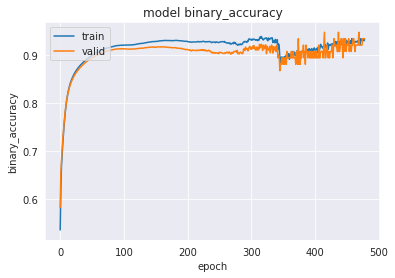

In [34]:
# summarize history for metric
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[1] + '.png'

adjustment_threshold_metric = 10#100
    
metric_df_adjusted = metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    metric_df_adjusted[metric_df_adjusted.columns] = np.where(metric_df_adjusted[metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, metric_df_adjusted[metric_df_adjusted.columns])
    
val_metric_df_adjusted = val_metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    val_metric_df_adjusted[val_metric_df_adjusted.columns] = np.where(val_metric_df_adjusted[val_metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, val_metric_df_adjusted[val_metric_df_adjusted.columns])

    
plt.plot(metric_df_adjusted.describe().loc['mean'].values)
plt.plot(val_metric_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[1])
plt.ylabel(list(history.keys())[1])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()


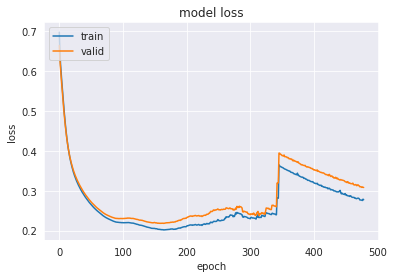

In [35]:
# summarize history for loss
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[0] + '.png'

adjustment_threshold_loss = 0#10000
    
loss_df_adjusted = loss_df.copy(deep=True).iloc[:,1:]

if adjustment_threshold_loss > 0:
    loss_df_adjusted[loss_df_adjusted.columns] = np.where(loss_df_adjusted[loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, loss_df_adjusted[loss_df_adjusted.columns])
    
val_loss_df_adjusted = val_loss_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_loss > 0:
    val_loss_df_adjusted[val_loss_df_adjusted.columns] = np.where(val_loss_df_adjusted[val_loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, val_loss_df_adjusted[val_loss_df_adjusted.columns])

    
plt.plot(loss_df_adjusted.describe().loc['mean'].values)
plt.plot(val_loss_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[0])
plt.ylabel(list(history.keys())[0])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()
